# The downstream tracking study based on xgboost .
## Study dive into the model's prediction

The goal of this notebook is to get better understanding of each of the featrres, that were used in order to build the xgboost model. 


In [41]:
print ("kernel is alive!")

kernel is alive!


In [42]:
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

# xgboost 
import xgboost as xgb
from xgboost import plot_importance

# sharp 
import shap


### As a very first step I need to grab training data form the NTpule. 
To obtain this goal I will use **root_numpy**, that allows me to convert root NTuple to pandas.Dataframe

In [4]:
train_data_file = "/data/work/mercury/Wessex/test/Brunel_BdJPsiKs_MagU_30k.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(np.float64)

target = data.is_downstream_reconstructible
features = features.drop(features.columns[0], axis=1)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.447929,1849.101146,1083.522737,27.0,0.0,12.0,-1418.736880,-143.095899,-0.722093,-0.038671
1,0.354945,10085.622823,1345.148537,24.0,0.0,12.0,-393.699553,-284.193871,-0.129122,-0.037920
2,2.906524,2441.534682,1013.888408,24.0,0.0,12.0,-834.004914,-270.235334,-0.456235,-0.015198
3,3.234916,2604.073941,904.097232,24.0,0.0,12.0,-475.119652,-230.380918,-0.369728,-0.018967
4,0.842265,2644.554049,1068.602364,23.0,0.0,12.0,-899.187260,-101.826800,-0.440227,-0.036610


### Print the features distributions

I want to know how doest the features looks like.

In [5]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06,2.415200e+06
mean,1.871657e+00,2.138872e+04,1.730661e+03,1.792164e+01,2.797962e+00,1.125978e+01,4.302253e-01,-4.526582e+00,-2.401685e-03,-5.792746e-04
std,1.274678e+00,1.528150e+06,6.397556e+04,4.672918e+00,4.762586e+00,1.028624e+00,7.095528e+02,5.222606e+02,3.068898e-01,6.750835e-02
min,1.030490e-03,1.121404e+03,2.736860e+00,8.000000e+00,0.000000e+00,8.000000e+00,-2.536045e+03,-2.368444e+03,-1.303497e+00,-4.931323e-01
25%,9.834252e-01,3.318111e+03,9.752144e+02,1.300000e+01,0.000000e+00,1.100000e+01,-3.969852e+02,-2.058561e+02,-1.735886e-01,-2.951513e-02
50%,1.494130e+00,6.400423e+03,1.153456e+03,1.900000e+01,0.000000e+00,1.200000e+01,9.255241e-01,-3.572218e+00,-3.683508e-03,-2.420115e-04
75%,2.391722e+00,1.445767e+04,1.406610e+03,2.200000e+01,4.000000e+00,1.200000e+01,4.014095e+02,1.991543e+02,1.691624e-01,2.868205e-02
max,8.999642e+00,1.741231e+09,5.879921e+07,3.400000e+01,2.300000e+01,1.200000e+01,2.511015e+03,2.224234e+03,1.307487e+00,4.260690e-01


In [8]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = np.percentile(features[feature], [1, 99])
        min_value-=0.1*max_value
        max_value+=0.2*max_value
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

In [ ]:
print_features_histograms(features, target)

# Feature Engenering

## Add transformated features

At the begining let's try some very basic feature transformation. 
I also add pseudorapidity and seed_r

In [6]:
def basic_transforamtion(data):
    #abs transformation
    out = data
    out["abs_seed_x"]=np.abs(data['seed_x'])
    out["abs_seed_y"]=np.abs(data['seed_y'])
    out["abs_seed_tx"]=np.abs(data['seed_tx'])
    out["abs_seed_ty"]=np.abs(data['seed_ty'])
    out['seed_r'] = np.sqrt(np.square(data.seed_x) +np.square(data.seed_y))    
    out['pseudo_rapidity'] = np.arctanh(data.seed_pt/data.seed_p)
    return out

In [7]:
new_data = basic_transforamtion(data)
new_features =  new_data.drop(["is_true_seed","has_MCParticle",
                    "is_downstream_reconstructible",
                    "has_MCParticle_not_electron",
                    "is_downstream_reconstructible_not_electron",
                    "seed_mva_value",
                    "seed_x",
                    "seed_y",
                    "seed_tx",
                    "seed_ty",
                    "Unnamed: 0"          ] , axis=1).astype(np.float64)

new_features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,abs_seed_x,abs_seed_y,abs_seed_tx,abs_seed_ty,seed_r,pseudo_rapidity
0,1.447929,1849.101146,1083.522737,27.0,0.0,12.0,1418.736880,143.095899,0.722093,0.038671,1425.935051,0.671511
1,0.354945,10085.622823,1345.148537,24.0,0.0,12.0,393.699553,284.193871,0.129122,0.037920,485.556891,0.134172
2,2.906524,2441.534682,1013.888408,24.0,0.0,12.0,834.004914,270.235334,0.456235,0.015198,876.693408,0.441959
3,3.234916,2604.073941,904.097232,24.0,0.0,12.0,475.119652,230.380918,0.369728,0.018967,528.028457,0.362240
4,0.842265,2644.554049,1068.602364,23.0,0.0,12.0,899.187260,101.826800,0.440227,0.036610,904.934487,0.428511


In [9]:
features_to_print = new_features[["seed_chi2PerDoF","seed_p",
                                "seed_pt",
                                "seed_nLHCbIDs",
                                "abs_seed_x",
                                "abs_seed_y",
                                "abs_seed_tx",
                                "abs_seed_ty",
                                "seed_r",
                                "pseudo_rapidity"]]
print_features_histograms(features_to_print, target)

NameError: name 'print_features_histograms' is not defined

# Explanation based on Shapley value

In [8]:
new_trainX, new_testX, new_trainY, new_testY = train_test_split(new_features, target, random_state=42,train_size=0.9 )
eval_set= [(new_trainX,new_trainY), (new_testX, new_testY)]
evals_result = {}
eval_metric=["error", "logloss", "auc"]

gb =xgb.XGBClassifier(n_estimators=300, learning_rate=0.049915496699718766, max_depth=11,
                 max_features= 0.3777993838461427,min_child_weight= 5,subsample= 0.4442307520949027, 
                    objective="gpu:binary:logistic", tree_method="gpu_exact",predictor='gpu_predictor',
                       silent=False, verbose_eval=True, eval_metric=eval_metric, evals_result=evals_result)
gb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
              evals_result={}, gamma=0, learning_rate=0.049915496699718766,
              max_delta_step=0, max_depth=11, max_features=0.3777993838461427,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='gpu:binary:logistic',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
              subsample=0.4442307520949027, tree_method='gpu_exact',
              verbose_eval=True)

In [9]:
%%time
gb.fit(new_trainX,new_trainY, eval_set=eval_set)

[0]	validation_0-error:0.146004	validation_0-logloss:0.665767	validation_0-auc:0.911521	validation_1-error:0.150807	validation_1-logloss:0.666072	validation_1-auc:0.908163
[1]	validation_0-error:0.139676	validation_0-logloss:0.640887	validation_0-auc:0.920305	validation_1-error:0.1447	validation_1-logloss:0.641483	validation_1-auc:0.917146
[2]	validation_0-error:0.140486	validation_0-logloss:0.61833	validation_0-auc:0.921837	validation_1-error:0.145537	validation_1-logloss:0.619193	validation_1-auc:0.918633
[3]	validation_0-error:0.13757	validation_0-logloss:0.597498	validation_0-auc:0.923754	validation_1-error:0.142584	validation_1-logloss:0.59868	validation_1-auc:0.920278
[4]	validation_0-error:0.137964	validation_0-logloss:0.57845	validation_0-auc:0.924257	validation_1-error:0.142932	validation_1-logloss:0.5799	validation_1-auc:0.920826
[5]	validation_0-error:0.13654	validation_0-logloss:0.560764	validation_0-auc:0.925596	validation_1-error:0.141827	validation_1-logloss:0.562509	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, eval_metric=['error', 'logloss', 'auc'],
              evals_result={}, gamma=0, learning_rate=0.049915496699718766,
              max_delta_step=0, max_depth=11, max_features=0.3777993838461427,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='gpu:binary:logistic',
              predictor='gpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
              subsample=0.4442307520949027, tree_method='gpu_exact',
              verbose_eval=True)

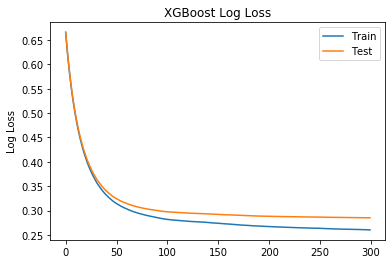

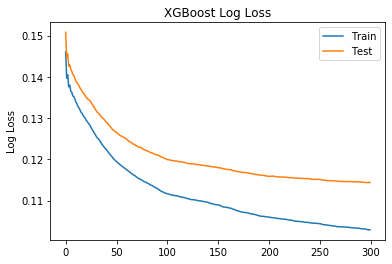

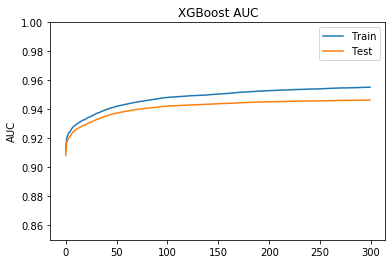

In [61]:
results = gb.evals_result()
epochs = len(results['validation_0']["error"])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["logloss"], label='Train')
ax.plot(x_axis, results['validation_1']["logloss"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["error"], label='Train')
ax.plot(x_axis, results['validation_1']["error"], label='Test')

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']["auc"], label='Train')
ax.plot(x_axis, results['validation_1']["auc"], label='Test')
plt.ylim(0.85,1)

ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

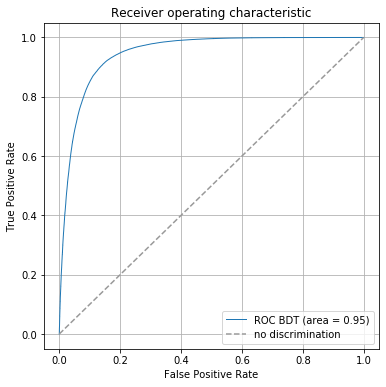

In [11]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(new_testY, gb.predict_proba(new_testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

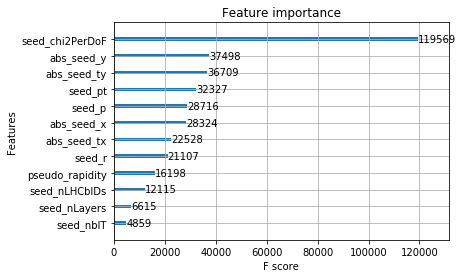

In [46]:
plot_importance(gb);

In [77]:
def plot_features_importance(model):
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

    for n, importance_type in enumerate(importance_types):
        # add sub plot on our figure
        ax = fig.add_subplot(len(importance_types) // 2+1, 2, n + 1)
        feature_important = gb.get_booster().get_score(importance_type=importance_type)
        keys = list(feature_important.keys())
        values = list(feature_important.values())

        column_name = "score: " + importance_type 
        data = pd.DataFrame(data=values, index=keys, columns=[column_name]).sort_values(by = column_name)
        data.plot(kind='barh', ax=ax);
        plt.xlabel("F score")
        ax.legend()

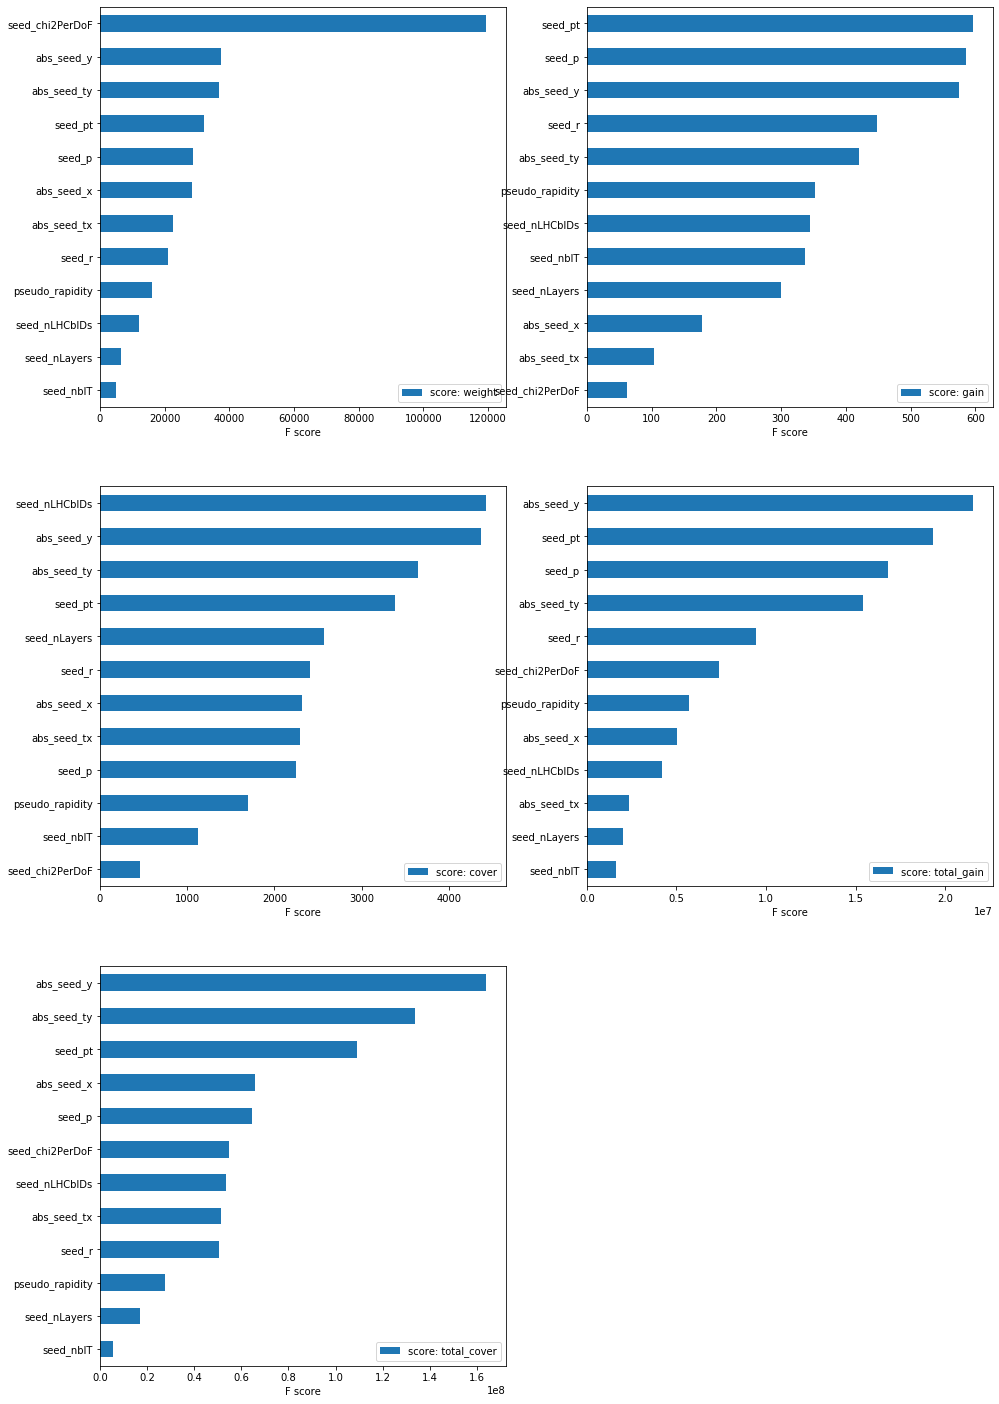

In [78]:
plot_features_importance(gb)

In [13]:
explainer = shap.TreeExplainer(gb)

In [17]:
shap_values = explainer.shap_values(new_testX[:5000] )

In [ ]:
shap_values_2 = explainer.shap_values(new_testX[:50000] )


In [20]:
import dill
dill.dump_session('xgboost_exp.db')


In [43]:
dill.load_session("xgboost_exp.db")

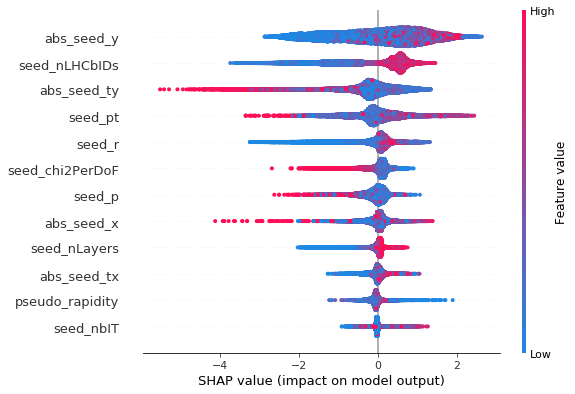

In [30]:
shap.summary_plot(shap_values_2, new_testX[:50000])


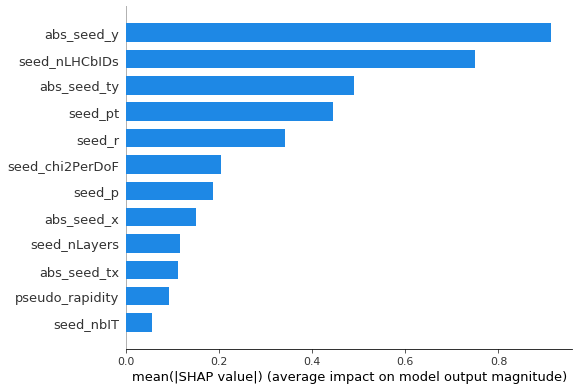

In [33]:
shap.summary_plot(shap_values_2, new_testX[:50000], plot_type="bar")


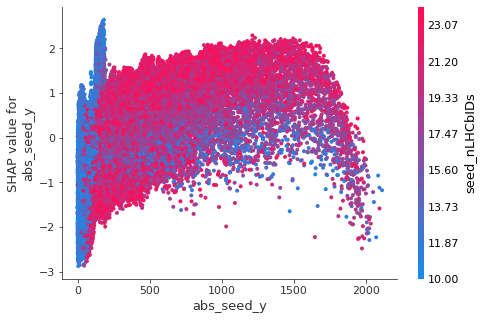

In [39]:
shap.dependence_plot("abs_seed_y", shap_values_2, new_testX[:50000] )

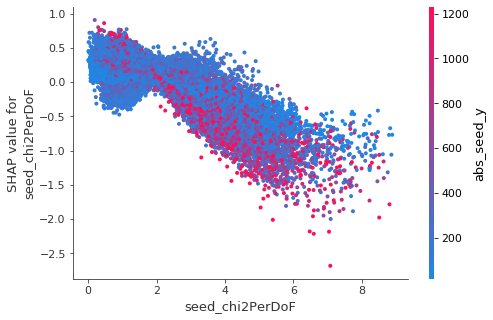

In [40]:
shap.dependence_plot("seed_chi2PerDoF", shap_values_2, new_testX[:50000] )

In [94]:
def plot_features_shapley_values(shapley_val, features):
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        #ax = fig.add_subplot(len(features) // 2+1, 2, n + 1)
        shap.dependence_plot(feature, shap_values_2, new_testX[:50000] )

In [95]:
new_testX.columns.to_list()

['seed_chi2PerDoF',
 'seed_p',
 'seed_pt',
 'seed_nLHCbIDs',
 'seed_nbIT',
 'seed_nLayers',
 'abs_seed_x',
 'abs_seed_y',
 'abs_seed_tx',
 'abs_seed_ty',
 'seed_r',
 'pseudo_rapidity']

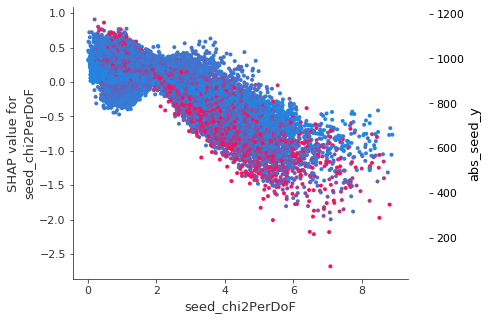

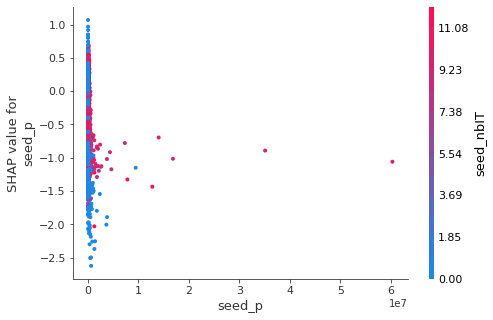

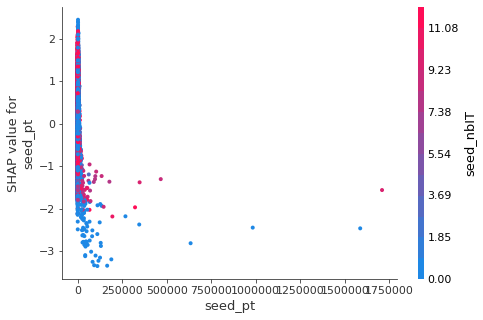

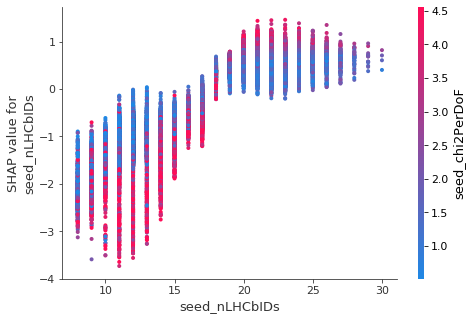

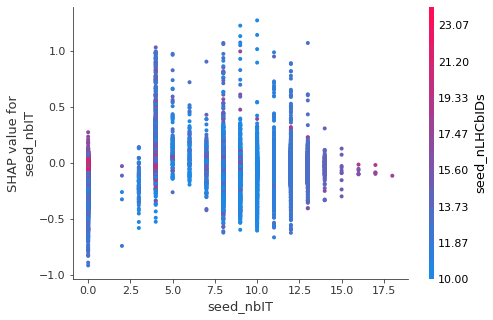

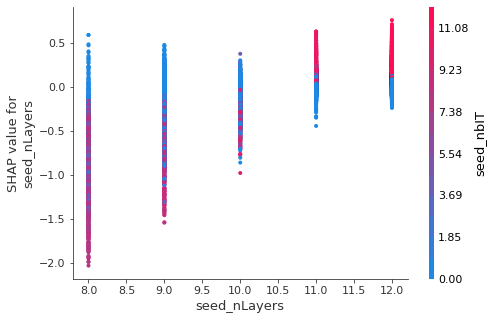

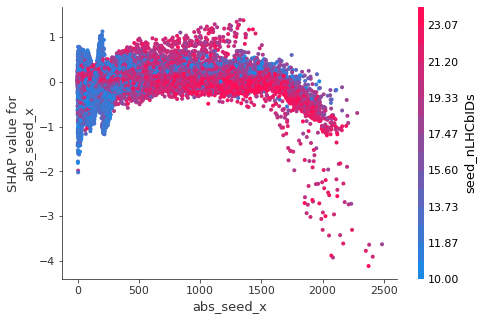

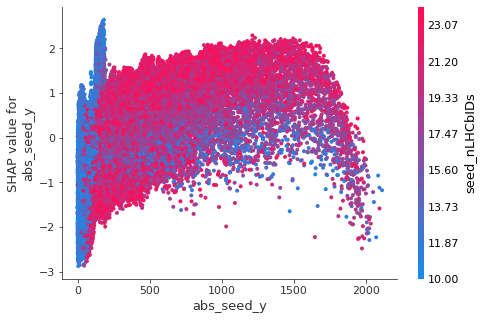

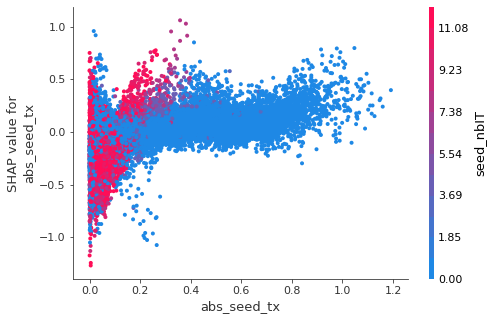

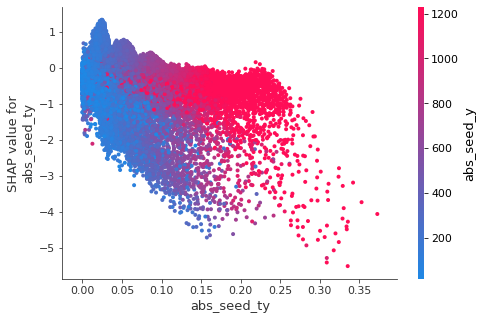

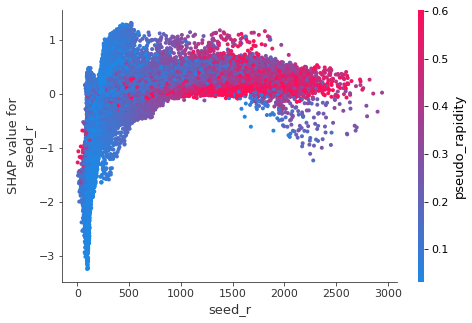

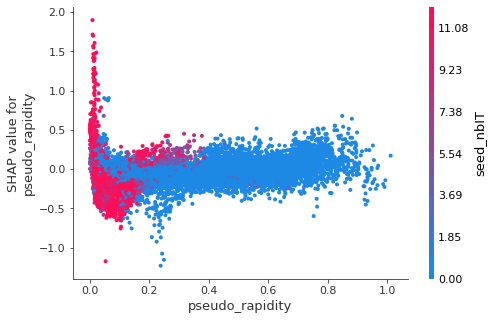

In [96]:
plot_features_shapley_values(shap_values_2, new_testX.columns.to_list())

In [ ]:
shap_interaction_values = shap.TreeExplainer(gb).shap_interaction_values(new_testX[:5000])


In [ ]:
shap_interaction_values